## Justin Butler
AAE 539 - Hw 1<br>
Spring 2020

In [1]:
# Importing required packages for this homework
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sympy as sym

%matplotlib inline

## Problem 1
Important information concerning the Raptor Engine:
\begin{align}
P_c &= 300 bar\\
T_c &= 3767 K\\
\gamma &= 1.2\\
\mathcal{M} &= 23 kg/kmol\\
t_b &= 70 s\\
h &= 50700\left(\frac{t}{t_b}\right)
\end{align}


In [113]:
#####################################################################
## This block contains functions and classes to be used throughout ##
#####################################################################

#Keep note of this rounding function.
## I use it throughout to change full float
## values to round to three decimal places.
def rounds(item):
    ret = float('%.3f'% (item * 1000/1000))
    return(ret)

# Atmospheric model created using the NASA equation found at:
# https://www.grc.nasa.gov/WWW/k-12/airplane/atmosmet.html
class atmosphere:
    def __init__(self, val, valGiven = 0,units = "SI"):
        #Convert from US to SI
        if units != "SI" and valGiven == 0:
            val = val / 3.281
        if units != "SI" and valGiven == 1:
            val = val * 0.04788
        #0 implies the given value is an altitude
        #1 implies the given value is a pressure
        if valGiven == 0:
            self.h = val
            self.hCalc()
        elif valGiven == 1:
            self.P = val
            self.PCalc()
        else:
            print("Not a valid 'valGiven' parameter.")
    def hCalc(self):
        if self.h < 11000:
            self.T = 15.04 - 0.00649*self.h
            self.P = 101.29 * ((self.T + 273.1)/288.08)**(5.256)
        elif self.h < 25000:
            self.T = -56.46
            self.P = 22.65 * np.exp(1.73 - 0.000157*self.h)
        elif self.h > 24999:
            self.T = -131.21 + 0.00299*self.h
            self.P = 2.488 * ((self.T + 273.1)/216.6)**(-11.388)
        self.rho = self.P / (0.2869 * (self.T + 273.1))
    def PCalc(self):
        if self.P > 22.632:
            self.T = (288.08*(self.P/101.29)**(1/5.256))-273.1
            self.h = (self.T - 15.04)/(-0.00649)
        elif self.P > 0.1113586:
            self.T = -56.46
            self.h = (1.73 - np.log((self.P/22.65)))/(0.000157)
        else:
            self.T = (216.6*(self.P/2.488)**(1/(-11.388)))-273.1
            self.h = (self.T + 131.21)/0.00299
        self.rho = self.P / (0.2869 * (self.T + 273.1))
# Plotting multiple graphs on one coordinate axis
def plot(x,y1,y2,title,axis=['x','y'],colors=['k','k'],labels=['','']):
    plt.figure(figsize=(10,5))
    plt.rc('xtick', labelsize=16)
    plt.rc('ytick', labelsize=16)
    #
    plt.plot(x,y1,'-',color=colors[0],label=labels[0])
    if y2 != []:
        plt.plot(x,y2,'-', color=colors[1],label=labels[1])
    #
    plt.title(title, fontsize=18)
    #plt.xlim(0,0.05)
    #plt.ylim(0,0.1)
    plt.xlabel(axis[0],fontsize=18)
    plt.ylabel(axis[1],fontsize=18)
    if labels[0] != '':
        plt.legend(loc=2, fontsize=16)
    #
    #plt.savefig('figure')
    #
    plt.show()
    plt.close()
    return(None)
# Trapezoid method for Approximate Integral
def Trapezoid(data):
    #Assuming evenly spaced points
    delX = np.abs(data[0][0]-data[1][0])
    yVal = [item[1] for item in data]
    trap = (delX/2)*(data[0][1]+data[-1][1] +
                    sum(2*yVal[1:-1]))
    return(trap)

In [3]:
## This block contains parameters given in the assignment ##
R_u = 8314.463 #m^3 Pa / K kmol
P_c = 300 * 100000 #Pascals
T_c = 3767
gamma = 1.2
mol = 23 #kg/kmol
t_b = 70 #s
def h(t):
    alt = 50700*(t/t_b) * 0.3048 #meters
    return(alt)

### PART A)
What is the mass flow through the nozzle?

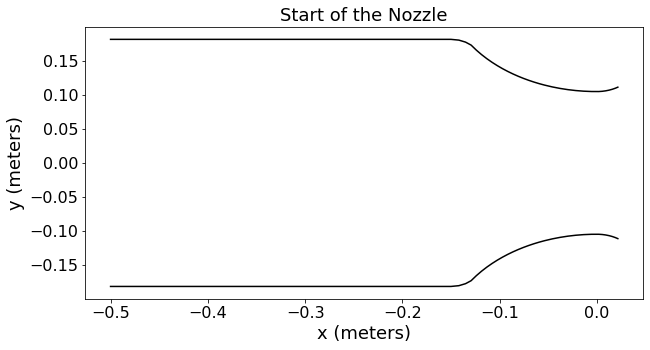

In [5]:
#Start by reading in the xml file

cwd = os.getcwd()
#print(cwd)
cf = pd.read_excel(r'contour.xlsx')
#print(cf.head())
xData = [cf.iloc[i,0] for i in range(len(cf.index))]
#print(xData)
y1Data = [cf.iloc[i,1] for i in range(len(cf.index))]
y2Data = [-data for data in y1Data]
#print(yData)

plot(xData,y1Data,y2Data,"Start of the Nozzle",axis=['x (meters)','y (meters)'])

In [6]:
#Finding the throat diameter
d_t = 10
for val in y1Data:
    dis = np.abs(val - (-val))
    if dis < d_t:
        d_t = dis
#From the throat diameter, find area of the throat
A_t = np.pi * (d_t/2)**2
#Find c*
cStar = np.sqrt((R_u*T_c)/(gamma*mol))*((gamma+1)/2)**((gamma+1)/(2*(gamma-1)))
print("The mass flow through the nozzle is:")
mDot = (P_c*A_t)/cStar
print(rounds(mDot),"kg/s")

The mass flow through the nozzle is:
571.917 kg/s


### Part b)
For a given exit area $A_e$ or expansion ratio $\varepsilon$, write a code which will calculate $C_f, I_{sp}$, and thrust as a function of time for this rocket.

In [60]:
#First, the function relating expansion ratio to mach
def fMach(eps,M,gamma=1.2):
    ans = eps - ( (1/M) *
                ((2+(gamma-1)*M**2)/(gamma+1))**((gamma+1)/(2*(gamma-1))))
    return(ans)
#Next, the derivative:
def fMachPrime(eps,M,gamma=1.2):
    ans = (( (2+(gamma-1)*M**2)/(gamma+1) )**((gamma+1)/(2*gamma-2)) /
          M**2
          ) - ( ((gamma-1)*M**2 + 2)/(gamma+1) 
              )**(((gamma+1)/(2*gamma-2))-1)
    return(ans)
#The C_f equation is complicated so I'm putting it here
def cfFunction(chamber, exit, ambient, expansion, gamma=1.2):
    ans = ( (((2*gamma**2)/(gamma-1)) *
          ((2/(gamma+1))**((gamma+1)/(gamma-1))) *
          (1 - (exit/chamber)**((gamma-1)/gamma)))**(1/2) +
          (exit/chamber - ambient/chamber)*expansion)
    return(ans)
#This is my method for finding c_f, F, and I_sp given an epsilon and throat area
def rocketStuff(massFlow,throatA,expansion,h=15.5*10**3,chamberP = 300*10**5,gamma=1.2):
    #Find the mach at the exit
    M_e = 5 #intial guess
    for i in range(50):
        save_M = M_e
        fM = fMach(expansion,M_e)
        fMP = fMachPrime(expansion,M_e)
        M_e = M_e - fM/fMP
        error = np.abs(M_e-save_M)
        if error < 0.0001:
            break
    #From exit mach, find the exit pressure:
    exitP = chamberP*(1 + ((gamma-1)/2)*M_e**2)**((-gamma)/(gamma-1))
    #Now, find ambient pressure from altitude
    atmos = atmosphere(h)
    ambientP = atmos.P * 1000 #Pascals
    #Next, we get the coefficient of thrust
    c_f = cfFunction(chamberP, exitP, ambientP, expansion, gamma)
    #Now, onto the thrust calculation
    F = c_f*chamberP*throatA
    #Finally, the I_sp
    I_sp = F/(massFlow*9.81)
    return([c_f,F,I_sp,M_e])

### Part c)
Using your code, plot $C_f, I_{sp}$ as a function of time for $\varepsilon = 10$ and $15$.

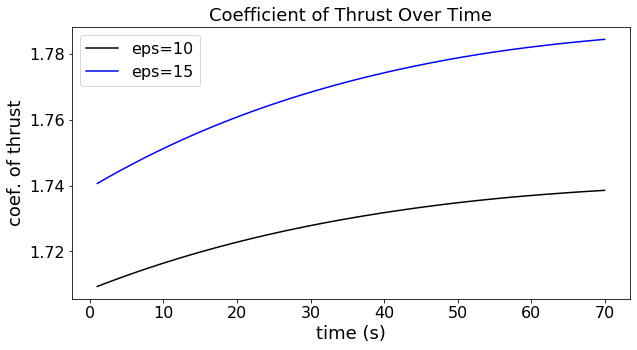

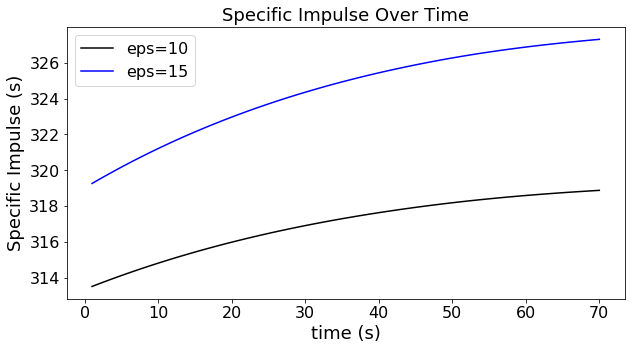

In [74]:
#Set up the parameter, t, as time and solve for heights
t = np.linspace(1,70,100)
hVals = [h(value) for value in t]
#Set up the empty lists I will be filling with values
c_f = [[],[]]
I_sp = [[],[]]
#Epsilon values
epsilon = [10,15]
for i in range(len(epsilon)):
    for jtem in hVals:
        #print("for eps = ",epsilon[i])
        #print(mDot,A_t,epsilon[i],jtem)
        output = rocketStuff(mDot,A_t,epsilon[i],jtem)
        c_f[i].append(output[0])
        I_sp[i].append(output[2])
plot(t,c_f[0],c_f[1],"Coefficient of Thrust Over Time",axis = ['time (s)','coef. of thrust'],
     colors=['k','b'],labels=['eps=10','eps=15'])
plot(t,I_sp[0],I_sp[1],"Specific Impulse Over Time",axis=['time (s)','Specific Impulse (s)'],
     colors=['k','b'],labels=['eps=10','eps=15'])


#### Part d)
Determine the optimal expansion ratio for the rocket.

In [65]:
'''
For this problem I will be attempting to find the expansion ratio that gives the highest total impulse
'''
#Set up the parameter, t, as time and solve for heights
t = np.linspace(1,70,500)
hVals = [h(value) for value in t]
#The different epsilon values I will try:
epsilon = np.linspace(1,60,60)
#Set up the list of lists that will be my thrust values
F = []
for i in range(len(epsilon)):
    F.append([])
#Now running through all of the epsilon values and grabbing the thrust values from them.
for i in range(len(epsilon)):
    for jtem in hVals:
        output = rocketStuff(mDot,A_t,epsilon[i],jtem)
        F[i].append(output[1])
#With the thrust values calculated, we now calculate the total impulse for each of these.
# To this end, we need to break apart the thrust values and tie them to a time step
integralReadyF = []
for i in range(len(F)):
    integralReadyF.append([[t[j],F[i][j]] for j in range(len(t))])
# With these properly apportioned, we now run through a numerical integration method as coded above
impulse = []
for item in integralReadyF:
    output = Trapezoid(item)
    impulse.append(output)
#Finally, we find the max of these values
maxVal = max(impulse)
index_max = np.argmax(impulse)
#And we print out what the best expansion ratio was
print("Expansion Ratio: ",epsilon[index_max],"\nWith a total impulse of",rounds(maxVal))

Expansion Ratio:  54.0 
With a total impulse of 130060115.007


### Part e)
Design an "80% bell" nozzle configuration using the expansion ratio from part c.

In [38]:
#Set the epsilon value we will be using:
eps = 54.0
#Let's start by getting some points of interest from our contour (using Pandas)
NCoord = [cf.iloc[-1,0],cf.iloc[-1,1]]
NSlope = [cf.iloc[-1,0],np.tan(33*(np.pi/180))]
thrIndex = np.argmin([cf.iloc[j,1] for j in range(len(cf.index))])
throatCoord = [cf.iloc[thrIndex,0], cf.iloc[thrIndex,1]] #We will use this coordinate point in part f
#Next we need information for the last point of our nozzle contour
length = 0.8*(( (d_t/2)*(np.sqrt(eps - 1)) + (0.382*(d_t/2))*(1/np.cos(15*(np.pi/180))-1))/
              np.tan(15*(np.pi/180)))
ESlope = [length,np.tan(6*(np.pi/180))]
r_e = np.sqrt((eps*A_t)/np.pi)
ECoord = [length,r_e]

[0.0217401719168273, 0.110933610175209] [2.275461296486863, 0.7678700460833785]


In [35]:
#Create a matrix equation to solve for the coefficients of the end-slope spline
def nozzleFit(point1,point2,slope1,slope2):
    A = [[point1[0]**3, point1[0]**2, point1[0], 1],
         [point2[0]**3, point2[0]**2, point2[0], 1],
         [3*slope1[0]**2, 2*slope1[0], 1, 0],
         [3*slope2[0]**2, 2*slope2[0], 1, 0]
        ]
    b = [[point1[1]],
         [point2[1]],
         [slope1[1]],
         [slope2[1]]
        ]
    coef = np.linalg.solve(A,b)
    return(coef)

Nozzle contour equation:
0.034x^3 + -0.237x^2 + 0.66x + 0.097


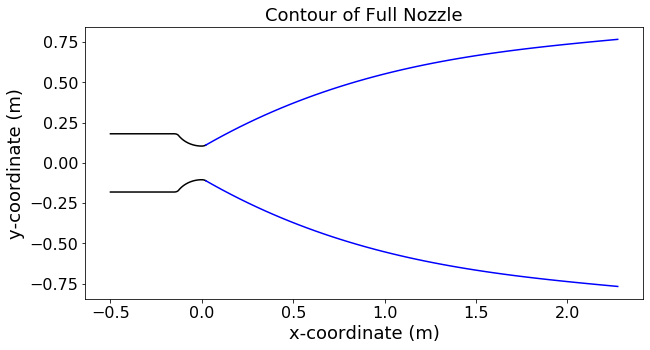

In [67]:
#Solve for the cubic function and plot
coef = nozzleFit(NCoord,ECoord,NSlope,ESlope)
#Set up a function to input x and output the nozzle geometry
def nozYCoord(x):
    y = coef[0]*x**3 + coef[1]*x**2 + coef[2]*x + coef[3]
    return(y)
print("Nozzle contour equation:\n"+str(rounds(coef[0]))+"x^3 + "+
      str(rounds(coef[1]))+"x^2 + "+ str(rounds(coef[2]))+"x + "+
      str(rounds(coef[3])))
#Set up the points to graph
nozX = np.linspace(NCoord[0],ECoord[0],50)
nozY = [nozYCoord(item) for item in nozX]
nozYFlip = [-item for item in nozY]

xData,y1Data,y2Data

## Time to plot! ##
plt.figure(figsize=(10,5))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
#
plt.plot(xData,y1Data,'-',color='k')
plt.plot(xData,y2Data,'-',color='k',label='Provided Contour')
plt.plot(nozX,nozY,'-',color='b')
plt.plot(nozX,nozYFlip,'-',color='b')
#
plt.title("Contour of Full Nozzle", fontsize=18)
#plt.xlim(0,0.05)
#plt.ylim(0,0.1)
plt.xlabel('x-coordinate (m)',fontsize=18)
plt.ylabel('y-coordinate (m)',fontsize=18)
#plt.legend(loc=2, fontsize=16)
#
#plt.savefig('figure')
#
plt.show()
plt.close()

### Part f)
Plot the nozzle contour, static pressure, static temperature, Mach number, and thrust coefficient as a function of $x$ for the altitude where optimum expansion is achieved.

In [76]:
## We will need to first determine the mach of the flow as a function of the x-coordinate.
#Since the expansion ratio is A_e/A_t, we will use the same method as before, but treating it as if
# the nozzle ended at whatever point we're looking at
areaArray = [np.pi*item**2 for item in nozY] #nozzle areas along the contour
expandArray = [item/A_t for item in areaArray] #Expansion ratios of those areas
#create empty array to fill with mach numbers
nozMach = []
#Finding mach values along the nozzle
for i in range(len(expandArray)):
    M_n = 5 #intial guess
    for j in range(50):
        save_M = M_n
        fM = fMach(expandArray[i],M_n)
        fMP = fMachPrime(expandArray[i],M_n)
        M_n = M_n - fM/fMP
        error = np.abs(M_n-save_M)
        if error < 0.0001:
            break
    nozMach.append(M_n[0])

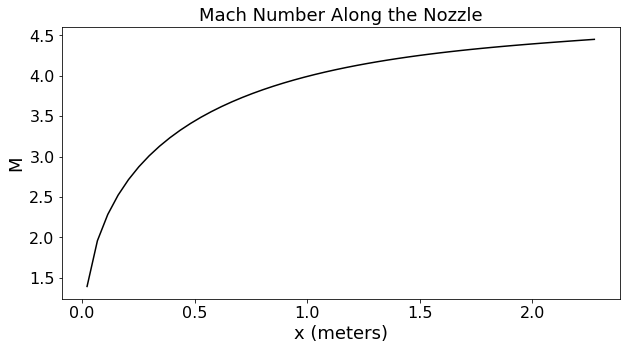

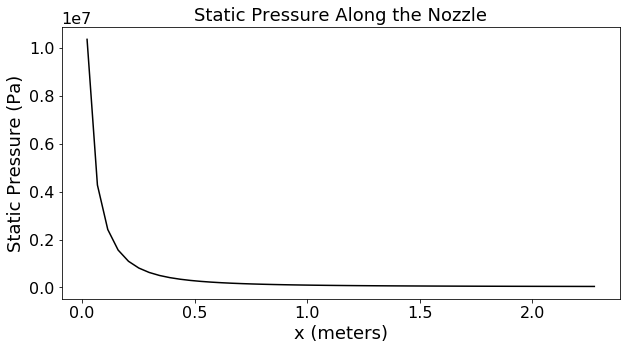

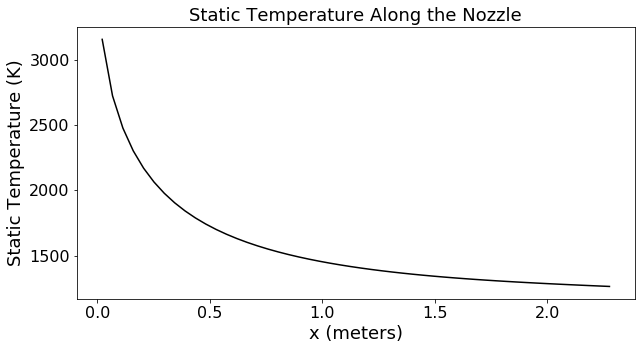

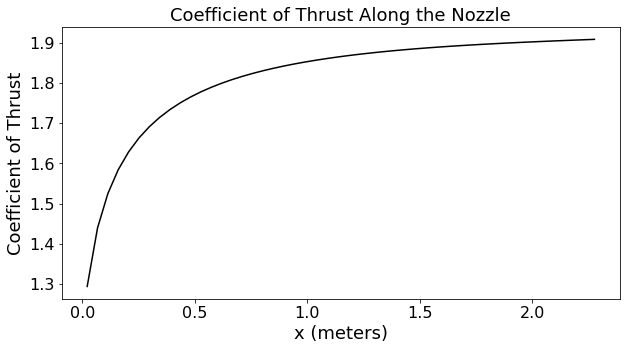

In [89]:
## We need to find the altitude of optimum expansion
M_e = nozMach[-1]
#From exit mach, find the exit pressure:
P_e = P_c*(1 + ((gamma-1)/2)*M_e**2)**((-gamma)/(gamma-1))
#Now, find altitude with this ambient pressure
atmos = atmosphere(P_e/1000, 1)
altOpt = atmos.h
P_Opt = atmos.P

## Next, we use this mach number to determine static temperature, pressure, and c_f along the nozzle ##
#Create empty arrays for these
nozP = []
nozT = []
nozC_f = []

## Now we iterate and solve for the required values
for i in range(len(nozMach)):
    outP = P_c * (1 + ((gamma-1)/2)*nozMach[i]**2)**((-gamma)/(gamma-1))
    outT = T_c * (1 + ((gamma-1)/2)*nozMach[i]**2)**(-1)
    outC_f = cfFunction(P_c, outP, P_Opt, expandArray[i])
    nozP.append(outP)
    nozT.append(outT)
    nozC_f.append(outC_f[0])
plot(nozX,nozMach,[],"Mach Number Along the Nozzle",axis=['x (meters)','M'])
plot(nozX,nozP,[],"Static Pressure Along the Nozzle",axis=['x (meters)','Static Pressure (Pa)'])
plot(nozX,nozT,[],"Static Temperature Along the Nozzle",axis=['x (meters)','Static Temperature (K)'])
plot(nozX,nozC_f,[],"Coefficient of Thrust Along the Nozzle",axis=['x (meters)','Coefficient of Thrust'])

### Part g)
Compare your thrust coefficient value at the exit plane with the value from the tables and discuss/explain any differences

In [93]:
print("My value of C_f: ",nozC_f[-1])
print("The tables' value of C_f optimal: 1.83129")
print("The tables' value of C_f vacuum: 1.90835")

My value of C_f:  1.9082731920454115
The tables' value of C_f optimal: 1.83129
The tables' value of C_f vacuum: 1.90835


Looking at the tables, the number I was able to calculate for $c_f$ was practically the same value as the vacuum coefficient of thrust for an expansion ratio of 54. 

### Part h)

## Problem 2
In this problem we will attempt to improve the performance of a rocket during its ascent through the atmosphere with the help of an extendible exit cone. The following properties can be used:
\begin{align}
c^* &= 1700 m/s\\
A_t &= 100 cm^2\\
\gamma &= 1.2\\
P_c &= 120 atm\\
t_b &= 115 sec\\
\text{Burnout Altitude: } &= 100km\\
\end{align}
EEC Specs:
\begin{align}
\varepsilon_1 = 15 & \text{ Deployed at 0 km}\\
\varepsilon_2 = 40 & \text{ Deployed at 25 km}\\
\varepsilon_3 = 60 & \text{ Deployed at 50 km}
\end{align}

In [98]:
#Set values for problem 2
cStar = 1700 #m/s
A_t = 100 * 0.0001 #m^2
gamma = 1.2 #ratio of specific heats
g = 9.81 #Acceleration due to gravity
P_c = 120 * 101325 #Pa
t_b = 115 #sec
h_max = 100 #km
eps = [15,40,60]

### Part a)
Plot the specific impulse for this rocket as a function of altitude assuming proper deployments of the extendible cones.

I'm going to do this a bit out of order. The reason for this is I want to have my altitudes based on a time for part b and having these calculations up above part a makes the code more streamlined. So the matrix solving that is discussed in part b is done in the following code block and the rest of part a continues afterwords.

In [108]:
#Creating a matrix equation to solve for a parabolic trajectory (constant acceleration)
## THIS IS MOSTLY FOR PART B ##
startPoint = [0,0] # [time, altitude]
endPoint = [115, 100000] # [time, altitude (m)]
startSlope = [0,0] # [time, velocity]
A = [[startPoint[0]**2, startPoint[0], 1],
     [endPoint[0]**2, endPoint[0], 1],
     [2*startSlope[0], 1, 0]
    ]
b = [[0],
     [100000],
     [0]
    ]
coef = np.linalg.solve(A,b)
coef = [coef[0][0],coef[1][0],coef[2][0]]
print("Parabolic Coefficients: ",coef)

Parabolic Coefficients:  [7.561436672967864, 0.0, 0.0]


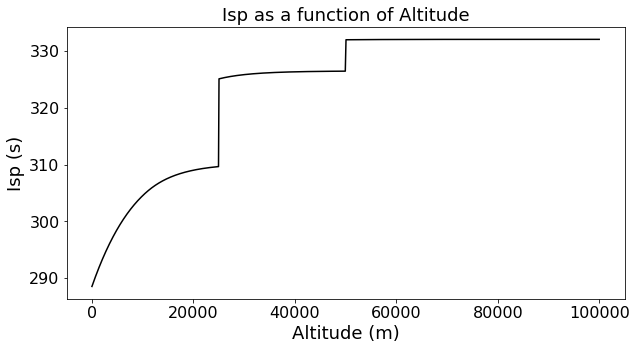

In [111]:
#First, we find mass flow
mDot = (P_c*A_t)/cStar

#Next, an array of altitude values from time. I don't need time dependence for part a, but it makes part b easier
t = np.linspace(0,115,1000)
h = [coef[0]*item**2 for item in t]

#Set up arrays of values for temperature and pressure to find ambient conditions
P_aArray = []
T_aArray = []
for item in h:
    atmos = atmosphere(item,0)
    P_aArray.append(atmos.P * 1000) #Atmosphere method used to find pressure in pascals
    T_aArray.append(atmos.T) #And the temperature too, just in case
#Find the exit mach number using Newton's Method
M_eArray = []
for item in h:
    M_e = 5 #intial guess
    #Make sure the proper expansion is occuring
    if item < 25*10**3:
        expansion = 15
    elif item < 50*10**3:
        expansion = 40
    else:
        expansion = 60
    #Run the newtons method
    for i in range(50):
        save_M = M_e
        fM = fMach(expansion,M_e)
        fMP = fMachPrime(expansion,M_e)
        M_e = M_e - fM/fMP
        error = np.abs(M_e-save_M)
        if error < 0.0001:
            break
    M_eArray.append(M_e)
#With each of the exit mach values, I will find exit pressure in pascals
P_eArray = []
for item in M_eArray:
    tempVal = P_c * (1 + ((gamma-1)/2)*item**2)**((-gamma)/(gamma-1))
    P_eArray.append(tempVal)
#I now have the pieces I need to find the coefficient of thrust
c_fArray = []
for i in range(len(h)):
    if h[i] < 25*10**3:
        tempVal = cfFunction(P_c, P_eArray[i], P_aArray[i], eps[0])
    elif h[i] < 50*10**3:
        tempVal = cfFunction(P_c, P_eArray[i], P_aArray[i], eps[1])
    else:
        tempVal = cfFunction(P_c, P_eArray[i], P_aArray[i], eps[2])
    c_fArray.append(tempVal)
#With c_f, I will find I_sp from equation 4.36 in Heister et. al.
I_spArray = [(item * cStar)/g for item in c_fArray]
plot(h,I_spArray,[],"Isp as a function of Altitude",axis=['Altitude (m)','Isp (s)'])


### Part b)
Determine total impulse delivered under nominal operation (assmuing constant massflow and acceleration).

Part of this problem required me to create an equation for a parabola which will map altitudes to times for a constant acceleration flight. This is actually included in one of the above code blocks for convienence.

In [117]:
#Create an array of force values
FArray = [mDot*g*item for item in I_spArray]
#Apportion the force values to the times they occur at
FTimeArray = [[t[i],FArray[i]] for i in range(len(t))]
#Use trapezoid rule to find total Impulse
I = Trapezoid(FTimeArray)
print("Total Impulse of the Rocket:",rounds(I),"Ns")

Total Impulse of the Rocket: 25389854.304 Ns


### Part c)
Repeat part (a) and (b) as if the nozzle never deployed.

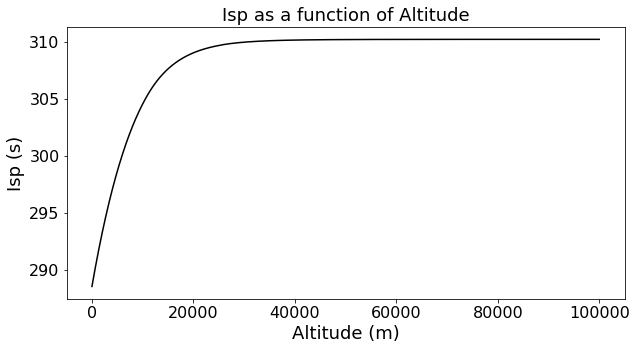

Total Impulse of the Rocket: 24604081.507 Ns


In [118]:
#Ambient conditions remain the same, so I will keep those from the previous work done
#Find the exit mach number using Newton's Method
M_eArray = []
for item in h:
    M_e = 5 #intial guess
    #Only one expansion ratio
    expansion = 15
    #Run the newtons method
    for i in range(50):
        save_M = M_e
        fM = fMach(expansion,M_e)
        fMP = fMachPrime(expansion,M_e)
        M_e = M_e - fM/fMP
        error = np.abs(M_e-save_M)
        if error < 0.0001:
            break
    M_eArray.append(M_e)
#With each of the exit mach values, I will find exit pressure in pascals
P_eArray = []
for item in M_eArray:
    tempVal = P_c * (1 + ((gamma-1)/2)*item**2)**((-gamma)/(gamma-1))
    P_eArray.append(tempVal)
#I now have the pieces I need to find the coefficient of thrust
c_fArray = []
for i in range(len(h)):
    #Only one expansion ratio
    tempVal = cfFunction(P_c, P_eArray[i], P_aArray[i], eps[0])
    c_fArray.append(tempVal)
#With c_f, I will find I_sp from equation 4.36 in Heister et. al.
I_spArray = [(item * cStar)/g for item in c_fArray]
plot(h,I_spArray,[],"Isp as a function of Altitude",axis=['Altitude (m)','Isp (s)'])
#Create an array of force values
FArray = [mDot*g*item for item in I_spArray]
#Apportion the force values to the times they occur at
FTimeArray = [[t[i],FArray[i]] for i in range(len(t))]
#Use trapezoid rule to find total Impulse
I = Trapezoid(FTimeArray)
print("Total Impulse of the Rocket:",rounds(I),"Ns")

### Part d)
If all of the extendible cones accidentally deployed just after lift off, the flow would become incredibly over-expanded. This over expansion could, in all likelyhood, lead to seperation within the nozzle and a drastic performace loss.

### Part e)
Calculate the speicif impulse and thrust for the full flow and seperation of part d. At what area ratio does separation occur and what altitude would full flow occur?

I will be using Kalt-Bendall to test for flow separation.

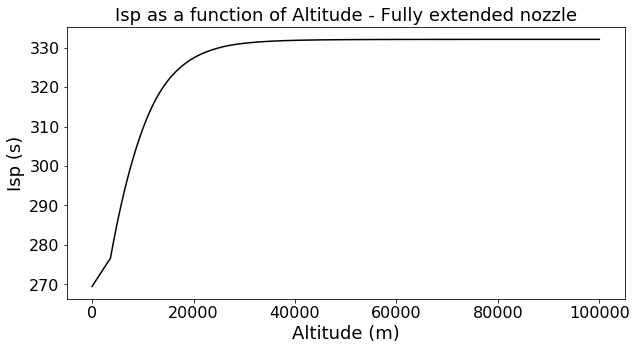

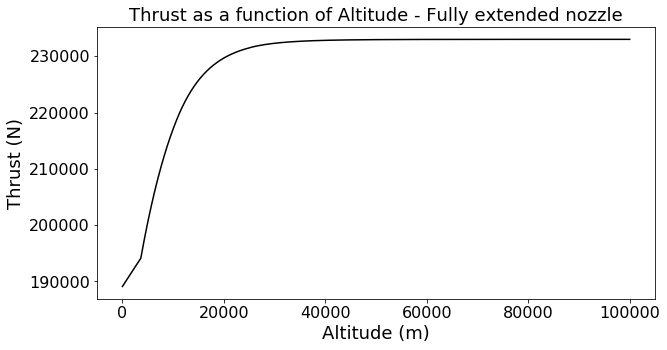

Total Impulse of the Rocket: 25329427.01 Ns
Altitude of full Flow:  3617.231 meters


,Altitudes (m),Separation?,Separation Pressure (Pa),Ideal Expansion Pressure (Pa),Expansion Ratio (full or separated)
0,0.000,True,25965.494,15190.532,39.289736
1,250.501,True,25055.193,15190.532,40.408735
2,1002.003,True,22483.712,15190.532,44.007173
3,2254.507,True,18691.536,15190.532,50.916018
4,4008.012,False,14296.604,15190.532,60.000000
5,6262.519,False,9951.788,15190.532,60.000000
6,9018.027,False,6201.005,15190.532,60.000000
7,12274.537,False,3392.404,15190.532,60.000000
8,16032.048,False,1671.337,15190.532,60.000000
9,20290.561,False,749.252,15190.532,60.000000


In [148]:
#Ambient conditions remain the same, so I will keep those from the previous work done
#Find the exit mach number using Newton's Method
M_eArray = []
for item in h:
    M_e = 5 #intial guess
    #Only one expansion ratio
    expansion = 60
    #Run the newtons method
    for i in range(50):
        save_M = M_e
        fM = fMach(expansion,M_e)
        fMP = fMachPrime(expansion,M_e)
        M_e = M_e - fM/fMP
        error = np.abs(M_e-save_M)
        if error < 0.0001:
            break
    M_eArray.append(M_e)
#With each of the exit mach values, I will find exit pressure in pascals
P_eArray = []
for item in M_eArray:
    tempVal = P_c * (1 + ((gamma-1)/2)*item**2)**((-gamma)/(gamma-1))
    P_eArray.append(tempVal)

## At this stage I deviate from the previous examples and check for separation
P_sepArray = []
for item in P_aArray: #Ambient pressure array from part (a)
    tempVal = item * 0.667 * (P_c/item)**(-0.2)
    P_sepArray.append(tempVal)
#We now do a check all along the flight to see if separation has occured. We set it either to True or False
sep = []
for i in range(len(P_eArray)):
    if P_eArray[i] < P_sepArray[i]:
        sep.append(True)
    else:
        sep.append(False)
        
#There are now two branching paths. If separation occured, I need to find the new expansion ratio to calculate
# all of the things I want. But first, array definitions:
c_fArray = []
I_spArray = []
FArray = []
separationList = [] #This is so I can pull out the separation Mach, Expansion, and Pressure
#Now onto the branching iteration
for i in range(len(sep)):
    # Separation has occured
    if sep[i]:
        M = ( ((P_sepArray[i]/P_c)**((gamma-1)/(-gamma)) - 1)
                   * (2/(gamma-1))
                  )**(1/2)
        expansion = ( (1/M) *
                   ((2 + (gamma-1)*M**2) / (gamma+1))**((gamma+1)/(2*gamma - 2))
                  )
        P_e = P_sepArray[i]
        separationList.append([M, expansion,P_e,h[i]])
    else:
        M = M_eArray[i]
        expansion = eps[2]
        P_e = P_eArray[i]
    tempVal1 = cfFunction(P_c, P_e, P_aArray[i], expansion)
    c_fArray.append(tempVal1)
    tempVal2 = (tempVal1 * cStar)/g
    I_spArray.append(tempVal2)
    tempVal3 = mDot * g * tempVal2
    FArray.append(tempVal3)
        
#Plotting the specific impulse and thrust
plot(h,I_spArray,[],"Isp as a function of Altitude - Fully extended nozzle",axis=['Altitude (m)','Isp (s)'])
plot(h,FArray,[],"Thrust as a function of Altitude - Fully extended nozzle",axis=['Altitude (m)','Thrust (N)'])
FTimeArray = [[t[i],FArray[i]] for i in range(len(t))]
#Use trapezoid rule to find total Impulse
I = Trapezoid(FTimeArray)
print("Total Impulse of the Rocket:",rounds(I),"Ns")

#Now creating tables for where separation occurs
#going at every 100th data point
hTable = h[0::50]
sepTable = sep[0::50]
P_eTable = P_eArray[0::50]
P_sepTable = P_sepArray[0::50]
eps_sepValues = [item[1] for item in separationList]
eps1 = eps_sepValues[0::50]
eps2 = [60 for i in range(16)]
epsTable = []
for i in range(20):
    if i<4:
        epsTable.append(eps1[i])
    else:
        epsTable.append(eps2[i-4])
#Configure the data in Pandas
data = {"Altitudes (m)":[rounds(item) for item in hTable],
       "Separation?":[str(item) for item in sepTable],
       "Separation Pressure (Pa)":[rounds(item) for item in P_sepTable],
       "Ideal Expansion Pressure (Pa)":[rounds(item) for item in P_eTable],
       "Expansion Ratio (full or separated)":epsTable}
#And output
constantDyn = pd.DataFrame(data)
print("Altitude of full Flow: ", rounds(separationList[-1][3]),"meters")
#constantDyn.to_csv(path+'\constantDynamicPressure.csv', index=False)
constantDyn